# <img style="float: left; padding-right: 0.7cm; width: 3.0cm" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/179px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png">IIC2440 - Procesamiento de Datos Masivos
Pontificia Universidad Católica de Chile<br>
Semestre 2023-1<br>
Profesores: Adrián Soto y Juan Reutter <br>
Estudiantes: Eduardo Alvarez F y Javier Arriagada S

----

In [1]:
!pip install pyspark

In [26]:
from pyspark import SparkConf, SparkContext
import numpy as np
import random
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# 2. Single Source Shortest Path

In [3]:
conf = SparkConf().setMaster("local").setAppName("PageRank")
sc = SparkContext(conf = conf)

Generamos un tamaño n de nodos, a partir de los cuales creamos n3/2 de aristas. (Para no importar un archivo, aunque igual se podria hacer de esa manera)

In [24]:
num_nodes = 100
nodes = list(range(1,num_nodes +1))
G = nx.Graph()
G.add_nodes_from(range(1, num_nodes + 1))

# el 3/2 es solo por facilidad. Aumentar de ser necesario
num_edges = int(num_nodes *3/2)
edges = []
for _ in range(num_edges):
    node1 = random.randint(1, num_nodes)
    node2 = random.randint(1, num_nodes)
    while node2 == node1 or G.has_edge(node1, node2):
      node2 = random.randint(1, num_nodes)
    G.add_edge(node1, node2)

    weight = random.randint(2, 20)
    edges.append((node1, node2, weight))


Grafico los nodos y las aristas para tener mas o menos una idea de los caminos (Para esta configuracion sirve tener un tamaño de 100 nodos y 150 aristas aprox)

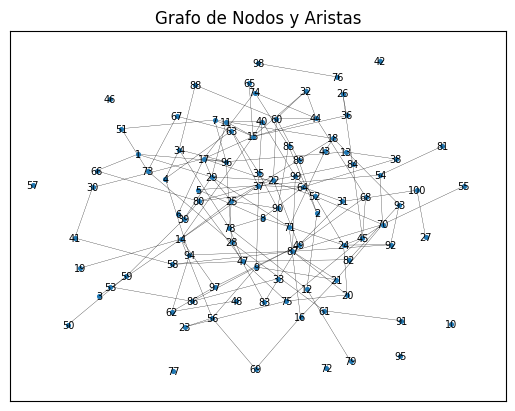

In [47]:
pos = nx.spring_layout(G, k=0.4)  # Layout algorithm for node positioning

# Draw the nodes with colors based on the 'category' attribute
nx.draw_networkx_nodes(G, pos, node_size=7)

# Draw the edges
nx.draw_networkx_edges(G, pos, width=0.2,node_size=8)

# Draw node labels if desired
nx.draw_networkx_labels(G, pos, font_size=7)

# Adjust the plot aesthetics
plt.title('Grafo de Nodos y Aristas')
#plt.axis('off')
# Display the graph
plt.show()

In [10]:
nodes_sssp_rdd = sc.parallelize(nodes)
edges_sssp_rdd = sc.parallelize(edges)

In [11]:
def initial_values(node, initial_node):
  if node != initial_node:
    return (node, float('inf'))
  return (node, 0)

In [18]:
initial_node = 4
node_sssp_rdd = nodes_sssp_rdd.map(lambda node: initial_values(node, initial_node))

In [14]:
def prepare_message(edge):
    src, dest, cost = edge
    return [(dest, current_cost + cost) for (node, current_cost) in actual_costs_list if node == src and current_cost != float('inf')]

def update_costs(node, costs):
    current_cost = costs
    if type(costs) == list():
      current_cost = float('inf')
      for cost in costs:
          if cost < current_cost:
              current_cost = cost
    return (node, current_cost)

In [21]:
max_iterations = 15
# por favor aumentar o disminuir el max_iterations a su gusto
iteration = 0
convergence_threshold = 2
consecutive_no_change = 0
actual_costs_list = node_sssp_rdd.collect()
actual_costs = node_sssp_rdd
while consecutive_no_change < convergence_threshold and iteration < max_iterations:
    # Genera los mensajes a partir de las aristas y los costos acumulados actuales
    messages = edges_sssp_rdd.flatMap(prepare_message)
    # Hacemos merge de los resultados
    messages = messages.reduceByKey(min)
    # Une los mensajes con los costos acumulados actuales y actualiza los costos
    actual_costs = actual_costs.union(messages).map(lambda x: update_costs(x[0], x[1])).reduceByKey(min)
    actual_costs_list = actual_costs.collect()

    # Verifica si ha habido cambios en los costos acumulados
    if iteration != 0:
      if previous_costs == actual_costs.collectAsMap():
          consecutive_no_change += 1
      else:
          consecutive_no_change = 0
    previous_costs = actual_costs.collectAsMap()

    iteration += 1

In [23]:
actual_costs.sortByKey(ascending=True).collect()

[(1, inf),
 (2, 80),
 (3, 81),
 (4, 0),
 (5, inf),
 (6, inf),
 (7, inf),
 (8, inf),
 (9, inf),
 (10, inf),
 (11, inf),
 (12, 90),
 (13, inf),
 (14, 67),
 (15, inf),
 (16, 70),
 (17, inf),
 (18, 9),
 (19, inf),
 (20, 19),
 (21, inf),
 (22, 25),
 (23, 98),
 (24, inf),
 (25, inf),
 (26, inf),
 (27, 6),
 (28, inf),
 (29, inf),
 (30, 43),
 (31, inf),
 (32, 13),
 (33, inf),
 (34, inf),
 (35, inf),
 (36, inf),
 (37, 58),
 (38, inf),
 (39, inf),
 (40, 94),
 (41, inf),
 (42, inf),
 (43, 90),
 (44, 73),
 (45, inf),
 (46, inf),
 (47, inf),
 (48, 83),
 (49, inf),
 (50, inf),
 (51, 80),
 (52, inf),
 (53, inf),
 (54, 79),
 (55, inf),
 (56, 92),
 (57, inf),
 (58, inf),
 (59, 109),
 (60, 83),
 (61, 63),
 (62, inf),
 (63, 83),
 (64, 29),
 (65, 96),
 (66, 107),
 (67, 103),
 (68, 123),
 (69, 29),
 (70, inf),
 (71, inf),
 (72, inf),
 (73, inf),
 (74, 109),
 (75, inf),
 (76, inf),
 (77, 97),
 (78, inf),
 (79, inf),
 (80, 121),
 (81, 108),
 (82, inf),
 (83, inf),
 (84, 113),
 (85, inf),
 (86, inf),
 (87, in

# 3. Una estrategia general

1. Preparación de los nodos:

Inicializar las propiedades de los nodos, como el valor de PageRank o la distancia más corta en el caso de SSSP.
Asignar un identificador único a cada nodo del grafo.

2. Regla para pasar mensajes entre nodos:

En cada iteración del algoritmo, cada nodo envía mensajes a sus vecinos para compartir información.
Los mensajes pueden contener información relevante para el cálculo, como el valor de PageRank actualizado o la distancia más corta encontrada.
Los nodos reciben los mensajes enviados por sus vecinos y los utilizan para actualizar su información local.

3. Definición de funciones para hacer merge de varios mensajes:

Los nodos pueden recibir múltiples mensajes de diferentes vecinos en una iteración.
Se debe definir una función de merge que combine los mensajes recibidos en uno solo, considerando la información relevante para el cálculo.
Por ejemplo, en el caso de PageRank, los mensajes contienen contribuciones de los vecinos al PageRank del nodo receptor, y la función de merge sumaría estas contribuciones para obtener el nuevo valor de PageRank.

4. Actualización de las propiedades de los nodos:

Después de cada iteración, los nodos actualizan sus propiedades locales con la información recibida de los mensajes.
Por ejemplo, en el caso de PageRank, los nodos actualizan su valor de PageRank con la suma de las contribuciones recibidas de los vecinos.

5. Condiciones de término del algoritmo:

Se debe establecer un criterio de convergencia para determinar cuándo el algoritmo ha terminado.
Por ejemplo, en el caso de PageRank, se puede definir un umbral de cambio máximo en los valores de PageRank de los nodos.
Si la diferencia entre los valores de PageRank de dos iteraciones consecutivas es menor que el umbral, se considera que el algoritmo ha convergido y se detiene.






Cambiamos de orden el 4 y el 5